In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
import random

# NOTE: I am ignoring the deprecation warnings on lmafit because I haven't found a way around them yet
warnings.filterwarnings("ignore")

cwd = os.getcwd()
par = os.path.join(cwd, os.pardir)
sys.path.append(par)

# I made some modules to make importing easier and to have a nice class
# that does all the matrix operations
import matrix_operation
import Dataset

In [2]:
# Just to reload the modules I imported above so I dont need to restart the kernel after making changes
import importlib
importlib.reload(matrix_operation)
importlib.reload(Dataset)

from matrix_operation import mat_opr
from Dataset import dataset

### Import and combine NYT and Big10

In [3]:
# hopefully this works on with your directory structure
# dset.nyt_df : NYT data
# dset.big10_df : Big10 data
# dset.combined and dset.dataframe are the combined version
dset = dataset()

# drop all zero rows and columns
dset.drop_zero_rows()
dset.drop_zero_cols()

# drop all rows where Big10 isn't complete
dset = dset.drop_bad_rows()

### Compare Input with NMF approximation

In [4]:
ranker = dset.rank_approx()
print(ranker)

1


In [5]:
ranker = 3

In [6]:
inp = dset.dataframe

nmfed = dset.sci_nmf(ranker)

### Graph Results

<AxesSubplot:title={'center':'Ohio State'}>

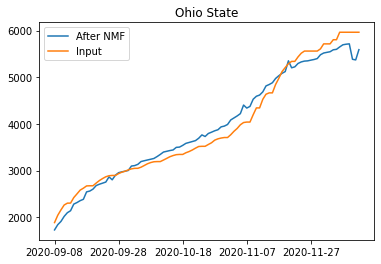

In [7]:
Ohio = pd.concat([inp['Ohio State'], nmfed.dataframe['Ohio State']], axis = 1)
Ohio.columns = ['Input', 'After NMF']
Ohio = Ohio.replace(0,np.nan)

Ohio.drop('Input',1).plot(kind = 'line',legend=True, title = 'Ohio State')
Ohio['Input'].plot(legend=True)

<AxesSubplot:title={'center':'Boston University'}>

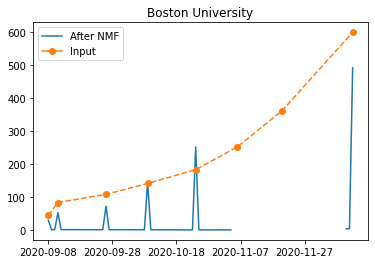

In [8]:
bu = pd.concat([inp['Boston University'], nmfed.dataframe['Boston University']], axis = 1)
bu.columns = ['Input','After NMF']
bu = bu.replace(0,np.nan)

bu.drop('Input',1).plot(kind = 'line',legend=True, title = 'Boston University')
bu['Input'].plot(marker='o',legend=True)
bu['Input'].interpolate(method='linear').plot(color = 'tab:orange', linestyle='--')

### Interpolate using Isotonic first?

In [9]:
with_iso = dset.iso(unk=0)

In [10]:
X,Y = with_iso.sci_nmf(ranker, separate=True)
dotted = pd.DataFrame(np.dot(X,Y))
dotted.index = with_iso.dataframe.index
dotted.columns = with_iso.dataframe.columns
iso_nmf = mat_opr(dotted)

<AxesSubplot:title={'center':'Boston University'}>

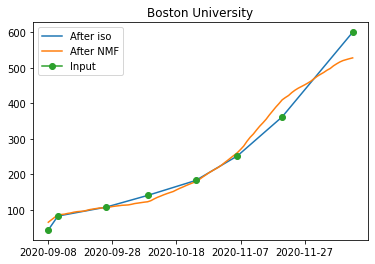

In [11]:
bu = pd.concat([inp['Boston University'],with_iso.dataframe['Boston University'], iso_nmf.dataframe['Boston University']], axis = 1)
bu.columns = ['Input','After iso','After NMF']

bu.drop('Input',1).plot(kind = 'line',legend=True, title = 'Boston University')

bu['Input'] = bu['Input'].replace(0,np.nan)
bu['Input'].plot(marker='o',legend=True)

### Look at the basis vectors

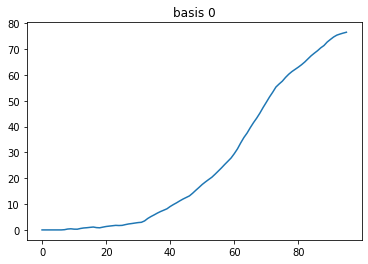

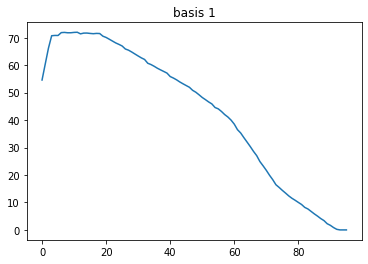

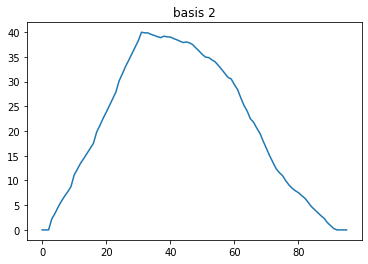

In [12]:
bases = pd.DataFrame(X)
    
for i in bases.columns:
    bases[i].plot()
    plt.title("basis " + str(i))
    plt.show()

### How to interpret these curves? -- Maybe infection rate or new cases per day?

In [13]:
def new_case_calc(data_obj, name=None, locr=None):
    if locr is None and name is None:
        return "need more arguments"
    
    elif locr is None:
        bosu = data_obj.dataframe[name]
    else:
        bosu = data_obj.dataframe.iloc[:,locr]

    new_cases = []
    for i in range(len(bosu)):
        if i == 0:
            new_cases.append(0)
        else:
            diff = bosu.iloc[i] - bosu.iloc[i-1]
            new_cases.append(diff)
            
    return new_cases
    
        

In [14]:
news = []
for i in range(len(with_iso.dataframe.columns)):
    news.append(new_case_calc(with_iso, locr=i))
    
new_case_frame = pd.DataFrame(news).T
new_case_frame.columns = with_iso.dataframe.columns
new_case_frame.index = with_iso.dataframe.index
new_cases = mat_opr(new_case_frame)

<AxesSubplot:>

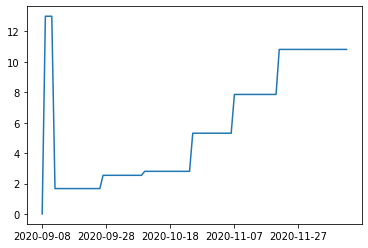

In [15]:
new_cases.dataframe['Boston University'].plot()

In [16]:
#locr = with_iso.dataframe.columns.get_loc('Boston University')
#x,y = with_iso.nmf(10, 'random', True)
#print(pd.DataFrame(y).iloc[:,locr])

## Clustering

In [17]:
def sort_by_cluster(labels):
    #helper function to see which columns are in which cluster
    cluster_dict = {lab:[] for lab in labels.value_counts().index}
    for i in range(len(labels)):
        cluster_dict[labels[i]].append(i) 
    return cluster_dict

In [18]:
def plot_cluster(data_obj, labels, mean = False, sample_size = 10):
    # plots a sample of data (or the mean of that sample) based on clustering results
    subs = labels.value_counts()
    fig, axs = plt.subplots(len(subs), figsize=(15,15))
    clust_dict = sort_by_cluster(labels)
    
    if mean == False:
        for i in clust_dict.keys():
            if sample_size > len(clust_dict[i]):
                for j in clust_dict[i]:
                    data_obj.dataframe.iloc[:,j].plot(ax=axs[i])
            else:
                samples = random.sample(clust_dict[i], sample_size)
                for j in samples:
                    data_obj.dataframe.iloc[:,j].plot(ax=axs[i])
    else:
        for k in clust_dict.keys():
            meaner = data_obj.dataframe.iloc[:,clust_dict[k]].mean(axis=1)
            meaner.plot(ax=axs[k])

### Cluster on original matrix (after isotonic)

In [19]:
kmeans = KMeans(n_clusters=ranker, random_state=9).fit(np.transpose(np.array(with_iso.array)))
county = pd.Series(kmeans.labels_)

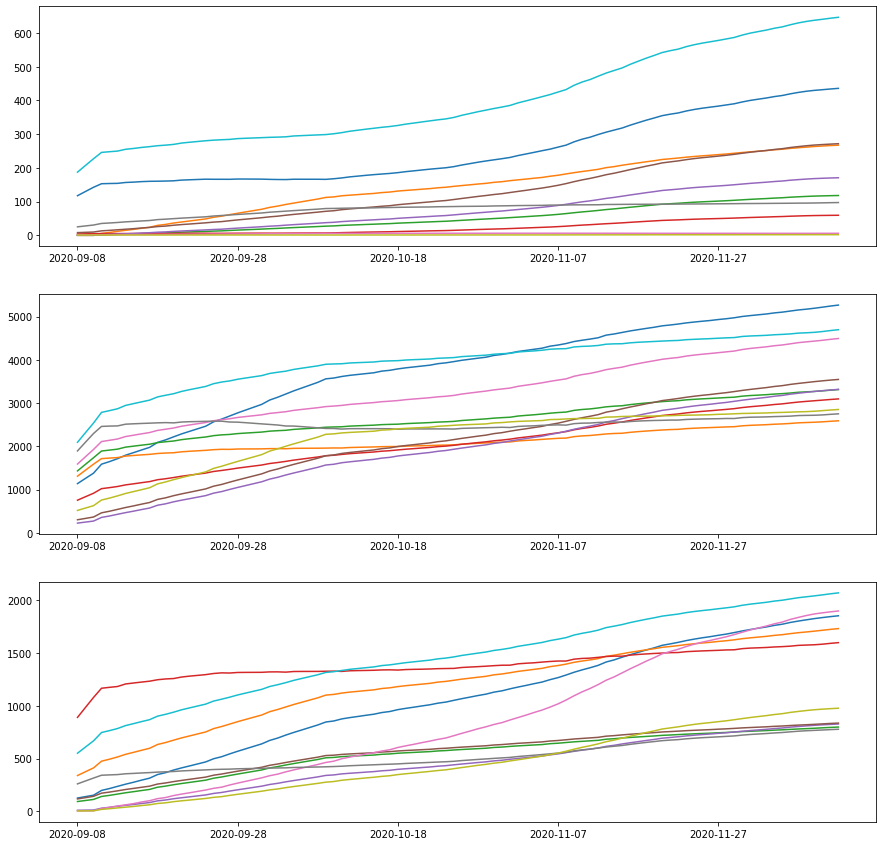

In [21]:
plot_cluster(iso_nmf, county, sample_size=10)

### Cluster the vectors of Y after decomposition

In [22]:
yer = np.transpose(np.array(Y))

In [23]:
kmeans = KMeans(n_clusters=ranker, random_state=9).fit(yer)
counter = pd.Series(kmeans.labels_)

In [24]:
counter.value_counts()

0    1733
1     114
2      25
dtype: int64

In [25]:
y_table = mat_opr(pd.DataFrame(yer).T)

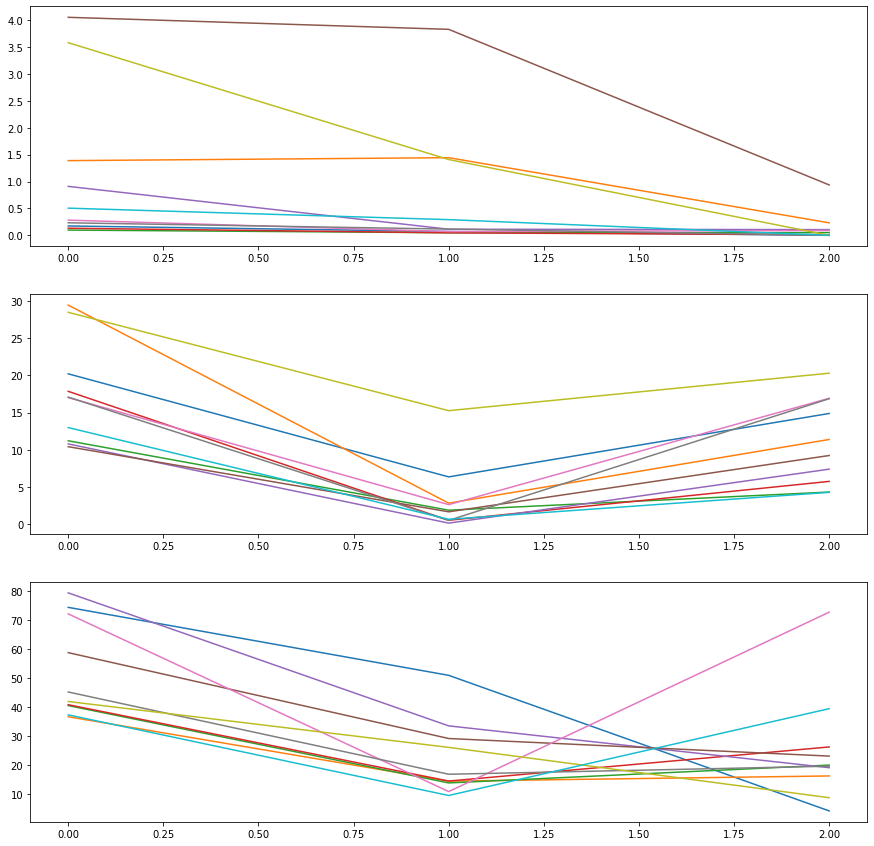

In [35]:
plot_cluster(y_table, counter)

### Plot case curves based on their cluster of Y

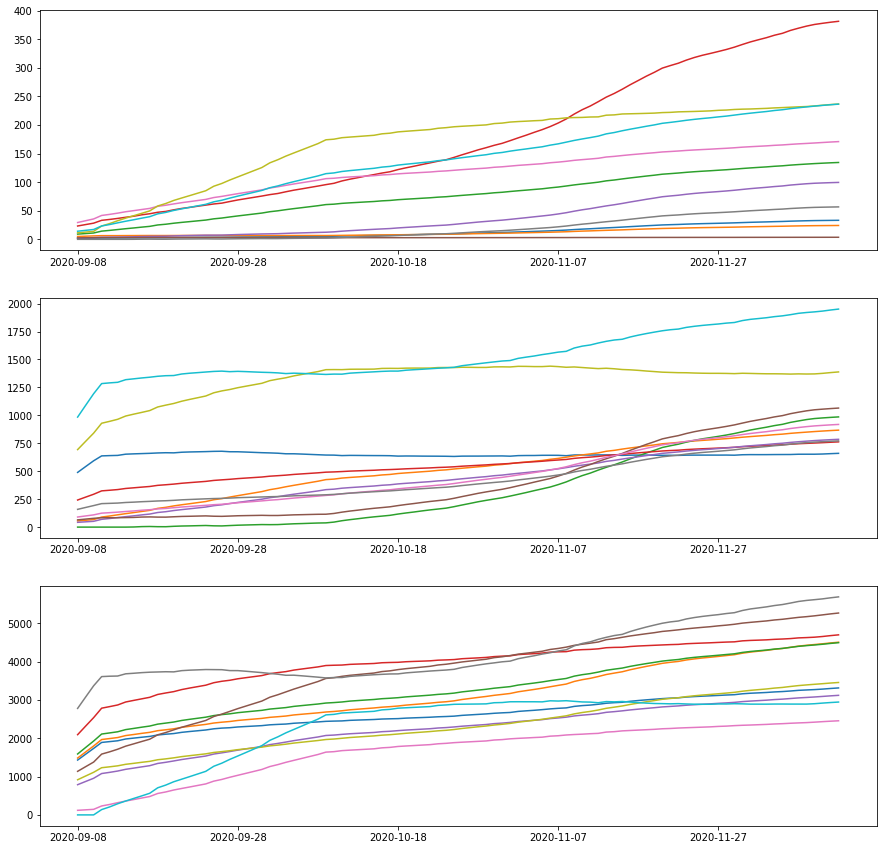

In [27]:
plot_cluster(iso_nmf, counter)

### Plot new case/day curves based on their cluster of Y

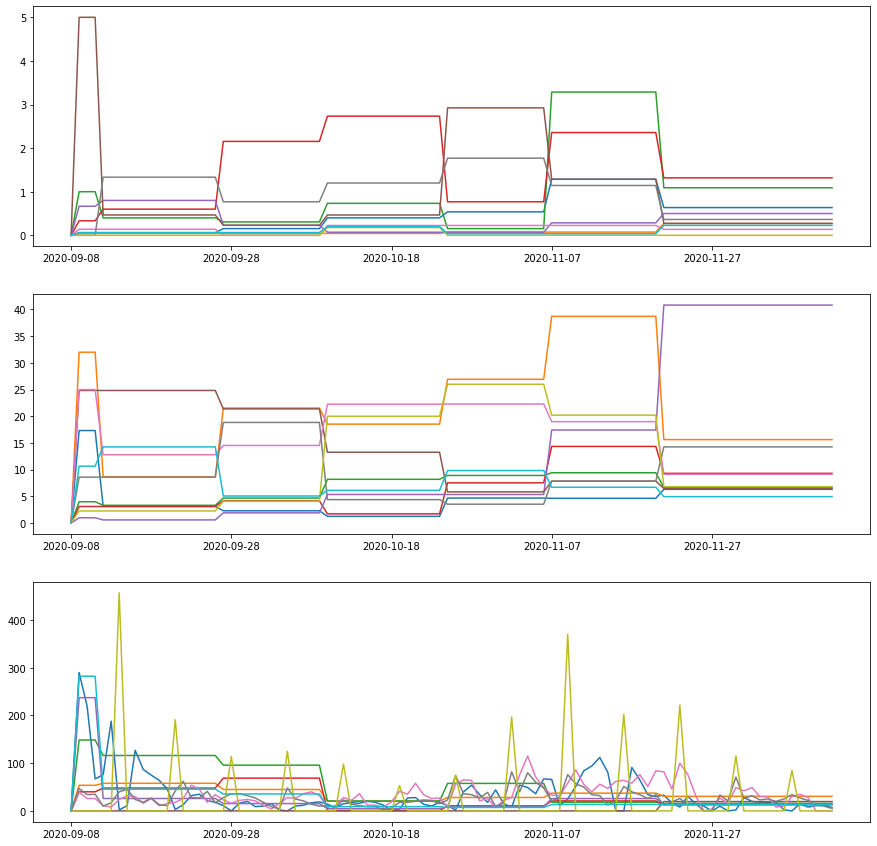

In [28]:
plot_cluster(new_cases, counter, sample_size=10)